In [1]:
import json 
import numpy as np
import sys

## merge museum metadata

In [302]:
# read file
def read_file(file_name:str)->list[dict]:
    '''
    file_name format: json
    '''
    data =[]
    with open(file_name,'rt') as f:
        for line in f:
            data.append(json.loads(line))
    
    return data

### wikipedia

In [ ]:
# wiki_filename_olist = './data_1101/wikipedia_museum_list.jsonl'
# wiki_filename_alist = './data_1101/wikipedia_added_list.jsonl'
# wiki_lists = read_file(wiki_filename_olist)
# wiki_lists.extend(read_file(wiki_filename_alist))

# with open('wikipedia_museum_list_merged.jsonl','wt') as f:
#     for museum in wiki_lists:
#         f.write(json.dumps(museum)+'\n')

In [320]:
wiki_filename_list = './data_1101/wikipedia_museum_list_merged.jsonl'
wiki_filename_articles = './data_1101/wikipedia_museum_articles3.jsnol'
wmuseum_filename = './data_1101/which_museum_museum_info.jsonl'

In [362]:
#read file 
wiki_list = read_file(wiki_filename_list)
wiki_articles = read_file(wiki_filename_articles)

In [17]:
# reconstruct list dictionary

# museum_ids = [museum['museum_id'] for museum in wiki_articles]
# wikipedia_museum_lists_merged =[]
# for museum in wiki_lists:
#     if museum['museum_id'] in museum_ids:
#         wikipedia_museum_lists_merged.append(museum)
# with open('wikipedia_museum_list_merge.jsonl','wt') as f:
#     for museum in wikipedia_museum_lists_merged:
#         f.write(json.dumps(museum)+'\n')

In [367]:
# keysset =set()

# for museum in wiki_list:
#     keys ='/'.join(list(museum.keys())[2:])
#     keysset.add(keys)
# with open('keyset.csv','wt') as f:
#     for key in keysset:
#         f.write(key+'\n')

# keysset

In [54]:
# with open('keyset.csv','wt') as f:
#     for line in keysset:
#         f.write(line+'\n')

In [323]:
def reconstruct_wiki_list(museum:dict[str,str])->dict[str,dict]:
    new_museum = {}
    for key,value in museum.items():
        key = key.lower()
        if 'name' in key:
            name = value[0]
        if key in ['museum_state']:
            new_museum[key] = value
        elif 'image' in key:
            new_museum['museum_wiki_image'] = value[1]
        elif key in ['type','subject','area of study']:
            new_museum['category'] = value[0]
        elif key in ['notes','summary']:
            new_museum['museum_wiki_decription'] = value[0]
        else:
            pass
        
    return {name:new_museum}

In [324]:
new_wiki_list ={}
for idx,museum in enumerate(wiki_list):
    new_wiki_list.update(reconstruct_wiki_list(museum))


In [338]:
list_names = list(new_wiki_list.keys())

In [326]:
def reconstruct_wiki_article(museum:dict)->dict:
    new_museum ={}
    others = {}
    
    for key,value in museum.items():
        key = key.lower()

        if key in ['museum_name','museum_url','img_url','coordinates','location','website','type']:
            new_museum[key] = value
        elif 'article' in key:
            new_museum['wiki_article'] = value
        elif ('nrhp' in key) or (key in ['museum_id']):
            pass
        else:
            others[key] = value
        
    new_museum['other'] = others

    return new_museum
    

In [327]:
new_wiki_articles = []

for idx,museum in enumerate(wiki_articles):
    single_museum = {'museum_id':idx}
    single_museum.update(reconstruct_wiki_article(museum))
    new_wiki_articles.append(single_museum)
    

In [329]:
museum_wiki_metadata =[]

for museum in new_wiki_articles:
    try:
        museum.update(new_wiki_list[museum['museum_name']])
    except KeyError:
        print(museum)
    
    img_url = []
    try:
        url1 = museum.pop('img_url')
        if len(url1)>0:
            img_url.append(url1)
    except:
        pass
    
    try:
        url2 = museum.pop('museum_wiki_image')
        if len(url2)>0:
            img_url.append(url2)
    except:
        pass
    
    museum['img_urls'] = img_url
    
    museum_wiki_metadata.append(museum)
        

In [312]:
with open('./data_1101/museum_wiki_metadata.jsonl','wt') as f:
    for museum in museum_wiki_metadata:
        f.write(json.dumps(museum)+'\n')

### which museum 

In [352]:
wmuseum_data = read_file(wmuseum_filename)
wiki_museums_names = {museum['museum_name']:idx for idx,museum in enumerate(museum_wiki_metadata)}

museum_metadata = []


num = 0
wmuseum_data2 = {}
for museum in wmuseum_data:
    new_museum = {}
    for key,value in museum.items():
        if key in ['Opening hours ', 'Admission ']:
            for idx,ele in enumerate(museum[key]):
                if type(museum[key]) == str:
                    museum[key] = museum[key].strip()
                elif type(museum[key]) == list:
                    museum[key][idx][1] = museum[key][idx][1].strip()
        
        if key not in ['museum_name','wmuseum_link']:
            new_museum[key.strip().lower()]=museum[key]        
        
    if museum['museum_name'] in wiki_museums_names:
       wmuseum_data2[museum['museum_name']] = new_museum
        

### data fushion

In [354]:
museum_wiki_metadata2 = []
for museum in museum_wiki_metadata:
    name = museum['museum_name'] 

    try:
        wmimg = wmuseum_data2[name].pop('image')
        museum['img_urls'] = museum['img_urls'].append(wmimg)
    except KeyError:
        pass

    try:
        museum['wm_description'] =  wmuseum_data2[name].pop('description')
    except KeyError:
        museum['wm_description'] =''

    try:
        museum.update(wmuseum_data2[name])
    except KeyError:
        pass
    
    museum_wiki_metadata2.append(museum)

In [356]:
with open('./data_1101/museum_wiki_metadata2.jsol','wt') as f:
    for museum in museum_wiki_metadata2:
        f.write(json.dumps(museum)+'\n')

In [368]:
museum_wiki_metadata =[]
with open('./data_1101/museum_wiki_metadata2.jsol','rt') as f:
    for line in f:
        museum_wiki_metadata.append(json.loads(line))


In [451]:
museum_category = []
for museum in museum_wiki_metadata:
    try:
        # museum_category.append(museum['category'])
        museum_category.append({'museum_id':museum['museum_id'],'museum_name':museum['museum_name'],'category':museum['category']})
    except KeyError:
        # museum_category.append('others')
        museum_category.append({'museum_id':museum['museum_id'],'museum_name':museum['museum_name'],'category':'unknown'})

In [458]:
from sentence_transformers import SentenceTransformer, util

def get_new_category(cat:str,cat20_emb,model:SentenceTransformer,cat20:list[str])->str:
        cat = cat.replace('-',' ').strip().lower()
        new_cat = []
        
        if cat  =='unknown':
           return ['others']
   
        else:
           for cat1 in cat20:
                if cat1 in cat:
                    new_cat.append(cat1)
                    
           if len(new_cat) ==0:
               cat_emb = model.encode(cat)
               scores = util.dot_score(cat_emb,cat20_emb)[0].cpu().tolist()
               scores_list = list(zip(cat20,scores))
               scores_list = sorted(scores_list,key = lambda x:x[1],reverse = True)
               new_cat.append('others')
               new_cat.extend([i[0] for i in scores_list[:2]])
               
               new_cat = list(set(new_cat))
        
           return new_cat

In [459]:
from tqdm import tqdm

cat20 = ['art','history','agriculture','transportation','ethnic','industry','military',\
        'open-air','aviation','maritime','religious','sports','hall of fame','science','music','religious','multiple','others']

model = SentenceTransformer('sentence-transformers/msmarco-MiniLM-L12-cos-v5')
cat20_emb = model.encode(cat20)
for idx,museum in tqdm(enumerate(museum_category),total = len(museum_category)):
# museum = museum_category[0]
        new_cat = get_new_category(museum['category'],cat20_emb,model,cat20)
        museum['new_category'] = new_cat


100%|██████████| 5741/5741 [00:47<00:00, 120.10it/s]


In [460]:
with open('./data_1101/museum_category.jsonl','wt') as f:
    for i in museum_category:
        f.write(json.dumps(i)+'\n')

In [467]:
from collections import Counter
total_category =[]
for i in museum_category:
    total_category.extend(i['new_category'])
count = Counter(total_category)

In [482]:

count = list(zip(count.keys(),count.values()))
sorted_count = sorted(count,key = lambda x:x[1],reverse =  True)

In [494]:
len(count)

47

<Axes: title={'center': 'distribution by state'}>

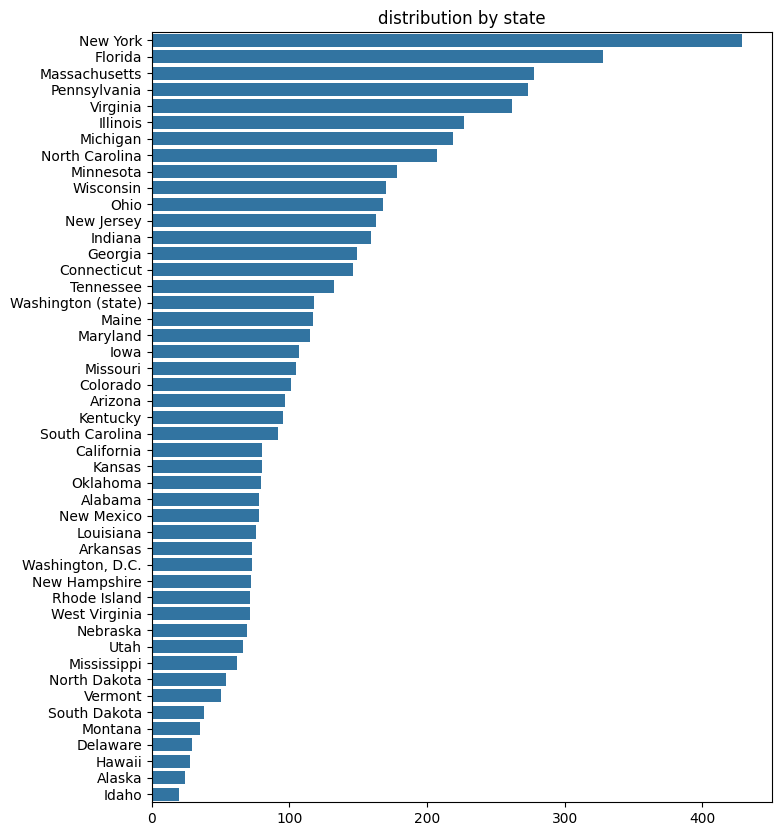

In [492]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,10))
plt.title('distribution by state')
sns.barplot(x=[i[1] for i in sorted_count],y = [i[0] for i in sorted_count],orient='h')
# plt.xticks(rotation = -90)

In [480]:
a = []
for i in museum_wiki_metadata2:
    a.append(i['museum_state'])
count = Counter(a)